In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l
import numpy as np

In [2]:
# 调用d2l中的函数会崩溃
def synthetic_data(w, b, num_samples):
    x = torch.randn(size=(num_samples, len(w)))
    y = torch.matmul(x, w) + b
    y = y + torch.randn(size=y.shape)
    return x, y

In [3]:
import torch.utils.data as data

def load_array(dataset, batch_size, is_train=True):
# Dataset wrapping tensors.
    dataset = data.TensorDataset(*dataset)
    if is_train:
        data_iter = data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    else:
        data_iter = data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return data_iter

In [4]:
n_train, n_test, num_inputs, batch_size = 20, 80, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05

In [5]:
train_data = synthetic_data(true_w, true_b, n_train)
train_iter = load_array(train_data, batch_size)

test_data = synthetic_data(true_w, true_b, n_test)
test_iter = load_array(test_data, batch_size, is_train=False)

In [6]:
def init_params():
    w = torch.randn(size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [7]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

def l1_penalty(w):
    return torch.sum(torch.abs(w))

In [22]:
def linereg(X, w, b):
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

# SGD函数存在问题
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [23]:
def train(lambd):
    w, b = init_params()
    net = lambda x: linereg(x, w, b)
    loss = squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())
    

w的L2范数是： 14.181048393249512


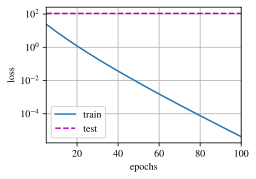

In [24]:
train(lambd=0)

w的L2范数是： 0.1640337109565735


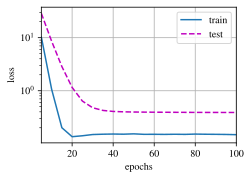

In [27]:
train(lambd=10)

## Pytorch简洁实现

In [16]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    num_epochs, lr = 100, 0.003
    loss = nn.MSELoss()
    optimizer = torch.optim.SGD([{
        "params": net[0].weight,
        'weight_decay': wd,
    }, {"params": net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                        xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

In [13]:
# 解决matplotlib无法显示数学符号的问题：https://www.codenong.com/47253462/
import matplotlib
# Customize matplotlib
matplotlib.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)


w的L2范数： 13.177711486816406


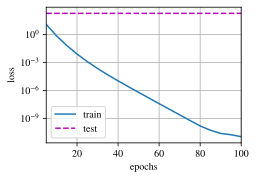

In [19]:
# 过拟合
train_concise(0)

w的L2范数： 0.5283898711204529


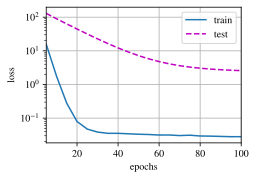

In [20]:
# 过拟合
train_concise(3)

w的L2范数： 0.2154027372598648


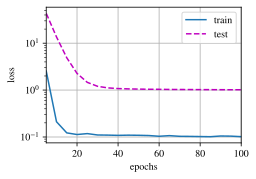

In [23]:
# 过拟合
train_concise(10)